In [56]:
#record path to each IP prefix of each peer
#record prefix table
#record as table
import pybgpstream
from tqdm.notebook import tqdm, trange
from datetime import timedelta, datetime
import json
import networkx as nx
from itertools import groupby
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import copy
import time

In [57]:
import random

    
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    '''
    From Joel's answer at https://stackoverflow.com/a/29597209/2966723.  
    Licensed under Creative Commons Attribution-Share Alike 
    
    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.
    
    G: the graph (must be a tree)
    
    root: the root node of current branch 
    - if the tree is directed and this is not given, 
      the root will be found and used
    - if the tree is directed and this is given, then 
      the positions will be just for the descendants of this node.
    - if the tree is undirected and not given, 
      then a random choice will be used.
    
    width: horizontal space allocated for this branch - avoids overlap with other branches
    
    vert_gap: gap between levels of hierarchy
    
    vert_loc: vertical location of root
    
    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''
    
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos

            
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

## 01/02/2020, 03:42 UTC unknown ip in AS328170 hijacked by AS64050

In [76]:
routeview_collector_lists = ["route-views.amsix", "route-views.bdix", "route-views.bknix", "route-views.chicago", \
                            "route-views.chile", "route-views.eqix", "route-views.flix", "route-views.fortaleza", \
                            "route-views.gixa", "route-views.gorex", "route-views.isc", "route-views.jinx", "route-views.kixp", \
                            "route-views.linx", "route-views.mwix", "route-views.napafrica", "route-views.nwax", "route-views.ny", \
                            "route-views.perth", "route-views.peru", "route-views.phoix", "route-views.rio", "route-views.saopaulo", \
                            "route-views.sfmix", "route-views.sg", "route-views.siex", "route-views.soxrs", "route-views.sydney", \
                            "route-views.telxatl", "route-views.uaeix", "route-views.wide", "route-views2", "route-views2.saopaulo", \
                            "route-views3", "route-views4", "route-views5", "route-views6"]
rcc_collector_lists = ["rrc00", "rrc01", "rrc03", "rrc04", "rrc05", "rrc06", "rrc07", "rrc10", "rrc11", "rrc12", "rrc10", "rrc11",
                      "rrc12", "rrc13", "rrc14", "rrc15", "rrc16", "rrc17", "rrc18", "rrc19", "rrc20", "rrc21", "rrc22", "rrc23",
                      "rrc24", "rrc25", "rrc26"]

In [5]:
print(f"Project Route Views has {len(routeview_collector_lists)} collectors.")

Project Route Views has 37 collectors.


In [77]:
#record as path to AS328170
start_time = time.time()
base_rib = defaultdict(dict)
for collector in tqdm(rcc_collector_lists):
    stream = pybgpstream.BGPStream(
        from_time="2020-01-01 23:59:59", until_time="2020-01-02 00:05:00",
        collectors=[collector],
        record_type="ribs",
        #if there is a IP prefix, uncomment the following and fill in IP prefix
        #filter = "prefix more [IP]"
    )
    as_path = defaultdict(dict)
    i = 0
    for rec in tqdm(stream.records()):
        for ele in rec:
            # Get the peer ASn
            i += 1
            peer = str(ele.peer_asn)
            hops = [k for k, g in groupby(ele.fields['as-path'].split(" "))]
            #print(ele)
            if str(ele.type) == "R":
                if 'as-path' and "prefix" in ele.fields and hops[-1] == "328170":
                    IP = ele.fields["prefix"]
                    as_path[IP][peer] = hops
    #break
    base_rib[collector] = as_path
    print(i)
print("--- %s seconds ---" % (time.time() - start_time))

  0%|          | 0/27 [00:00<?, ?it/s]

0it [00:00, ?it/s]

51077200


0it [00:00, ?it/s]

20763306


0it [00:00, ?it/s]

20070452


0it [00:00, ?it/s]

4732601


0it [00:00, ?it/s]

5361166


0it [00:00, ?it/s]

2601585


0it [00:00, ?it/s]

5389803


0it [00:00, ?it/s]

12311022


0it [00:00, ?it/s]

8090503


0it [00:00, ?it/s]

19565755


0it [00:00, ?it/s]

12311022


0it [00:00, ?it/s]

8090503


0it [00:00, ?it/s]

19565755


0it [00:00, ?it/s]

10861942


0it [00:00, ?it/s]

7013512


0it [00:00, ?it/s]

19489000


0it [00:00, ?it/s]

3448077


0it [00:00, ?it/s]

0


0it [00:00, ?it/s]

1645490


0it [00:00, ?it/s]

7353858


0it [00:00, ?it/s]

19186426


0it [00:00, ?it/s]

16886886


0it [00:00, ?it/s]

2419663


0it [00:00, ?it/s]

2640957


0it [00:00, ?it/s]

1925187


0it [00:00, ?it/s]

0


0it [00:00, ?it/s]

0
--- 3095.2990674972534 seconds ---


In [60]:
base_rib

defaultdict(dict,
            {'route-views.amsix': defaultdict(dict,
                         {'45.192.128.0/19': {'267613': ['267613',
                            '37100',
                            '328170'],
                           '50763': ['50763', '37100', '328170'],
                           '34968': ['34968', '37100', '328170'],
                           '39591': ['39591', '37100', '328170'],
                           '6830': ['6830', '3356', '37100', '328170'],
                           '293': ['293', '2914', '37100', '328170'],
                           '51088': ['51088', '6453', '37100', '328170'],
                           '39120': ['39120', '37100', '328170'],
                           '20953': ['20953', '37100', '328170'],
                           '58511': ['58511', '37100', '328170'],
                           '61955': ['61955', '37100', '328170'],
                           '31019': ['31019', '37100', '328170'],
                           '12779': ['12779

In [78]:
with open(f"Experiment_3/prefixASpath_rcc_01_02_2020_000000_as328170.json", "w") as f:
    json.dump(base_rib, f)

In [29]:
#Read update message until 14:05:00


In [79]:
rib_after_incident = copy.deepcopy(base_rib)
i = 0
start_time = time.time()
types = {"A", "W"}
#target_IP = "113.208.95.0/24"

for collector in tqdm(rcc_collector_lists):
    if rib_after_incident[collector]:
        stream1 = pybgpstream.BGPStream(
            from_time="2020-01-02 00:00:00", until_time="2020-01-02 03:50:00",
            collectors=[collector],
            record_type="updates",
        )
        i = 0
        target_IP = set(rib_after_incident[collector].keys())
        for rec in tqdm(stream1.records()):
            for elem in rec:
                if (str(elem.type) in types) and "prefix" in elem.fields:
                    IP = str(elem.fields["prefix"])
                    if IP in target_IP:
                        i += 1
                        if str(elem.type) == "A" and "as-path" in elem.fields:
                            peer = str(elem.peer_asn)
                            hops = [k for k, g in groupby(elem.fields['as-path'].split(" "))]
                            rib_after_incident[collector][IP][peer] = hops
                            if hops[-1] == "64050":
                                print(elem)
                        if str(elem.type) == "W":
                            peer = str(elem.peer_asn)
                            rib_after_incident[collector][IP][peer] = []
        print(i)
print("--- %s seconds ---" % (time.time() - start_time))

  0%|          | 0/27 [00:00<?, ?it/s]

0it [00:00, ?it/s]

69


0it [00:00, ?it/s]

0


0it [00:00, ?it/s]

0


0it [00:00, ?it/s]

0


0it [00:00, ?it/s]

0


0it [00:00, ?it/s]

0


0it [00:00, ?it/s]

0


0it [00:00, ?it/s]

0


0it [00:00, ?it/s]

0


0it [00:00, ?it/s]

6


0it [00:00, ?it/s]

0


0it [00:00, ?it/s]

0


0it [00:00, ?it/s]

6


0it [00:00, ?it/s]

0


0it [00:00, ?it/s]

0


0it [00:00, ?it/s]

152


0it [00:00, ?it/s]

0


0it [00:00, ?it/s]

0


0it [00:00, ?it/s]

0


0it [00:00, ?it/s]

6


0it [00:00, ?it/s]

0


0it [00:00, ?it/s]

0


0it [00:00, ?it/s]

0


0it [00:00, ?it/s]

0
--- 2446.0051844120026 seconds ---


In [85]:
with open("Experiment_3/prefixASpath_rcc_01_02_2020_034300_as328170.json", "w") as f:
    json.dump(rib_after_incident, f)

In [86]:
rib_after_incident == base_rib

True

In [82]:
#see if any AS paths to an IP from a peer changed before and after the incident
collector_IP_pair = []
for collector in tqdm(rcc_collector_lists):
    if rib_after_incident[collector] != base_rib[collector]:
        for IP in rib_after_incident[collector].keys():
            if rib_after_incident[collector][IP] != base_rib[collector][IP]:
                collector_IP_pair.append((collector, IP))

  0%|          | 0/27 [00:00<?, ?it/s]

In [83]:
collector_IP_pair

[]

In [46]:
## Create graph at each timestamp
## plot all paths from peer to IP address '91.227.149.0/24' and connect IP with the last on hop
as_graph_rib = nx.Graph()
for collector in routeview_collector_lists:
    if base_rib[collector]:
        peers = base_rib[collector].keys()
        for peer in peers:
            if base_rib[collector][peer]:
                des_list = base_rib[collector][peer].keys()
                for des in des_list:
                    as_path = base_rib[collector][peer][des]
        
                    for i in range(0, len(as_path)-1):
                        as_graph_rib.add_edge(as_path[i], as_path[i+1])
                    if len(as_path) > 0:
                        as_graph_rib.add_edge(as_path[-1], '113.208.95.0/24')

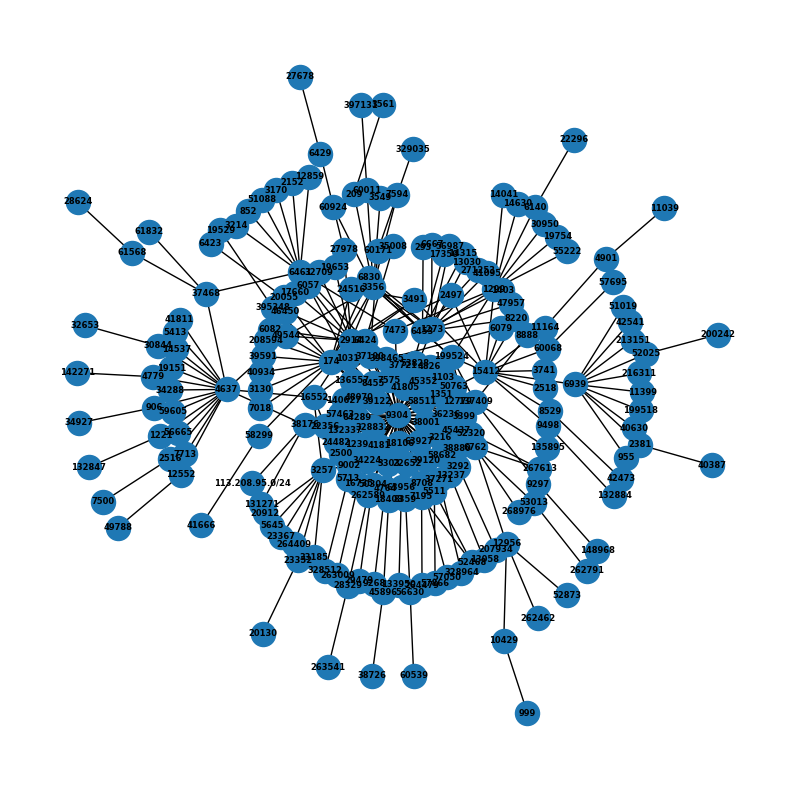

In [48]:
#pos = hierarchy_pos(as_graph_rib, '104.244.42.0/24')
pos = nx.kamada_kawai_layout(as_graph_rib)
ax = plt.subplots(1, figsize=(10, 10))
nx.draw(as_graph_rib, pos=pos, with_labels=True, font_weight='bold', font_size=6)
plt.savefig("ip11320895024_routeview_10_07_2024_160000_rib.png")

In [49]:
pos = hierarchy_pos(as_graph_rib, '91.227.149.0/24')
#pos = nx.kamada_kawai_layout(as_graph_rib)
ax = plt.subplots(1, figsize=(10, 10))
nx.draw(as_graph_rib, pos=pos, with_labels=True, font_weight='bold', font_size=6)
plt.savefig("ip11320895024_routeview_10_07_2024_160000_treerib.png")

TypeError: cannot use hierarchy_pos on a graph that is not a tree

In [50]:
##Graph after incident
as_graph_after = nx.Graph()
for collector in routeview_collector_lists:
    if rib_after_incident[collector]:
        peers = rib_after_incident[collector].keys()
        for peer in peers:
            if rib_after_incident[collector][peer]:
                des_list = rib_after_incident[collector][peer].keys()
                for des in des_list:
                    as_path = rib_after_incident[collector][peer][des]
        
                    for i in range(0, len(as_path)-1):
                        as_graph_after.add_edge(as_path[i], as_path[i+1])
                    if len(as_path) > 0:
                        as_graph_after.add_edge(as_path[-1], '113.208.95.0/24')

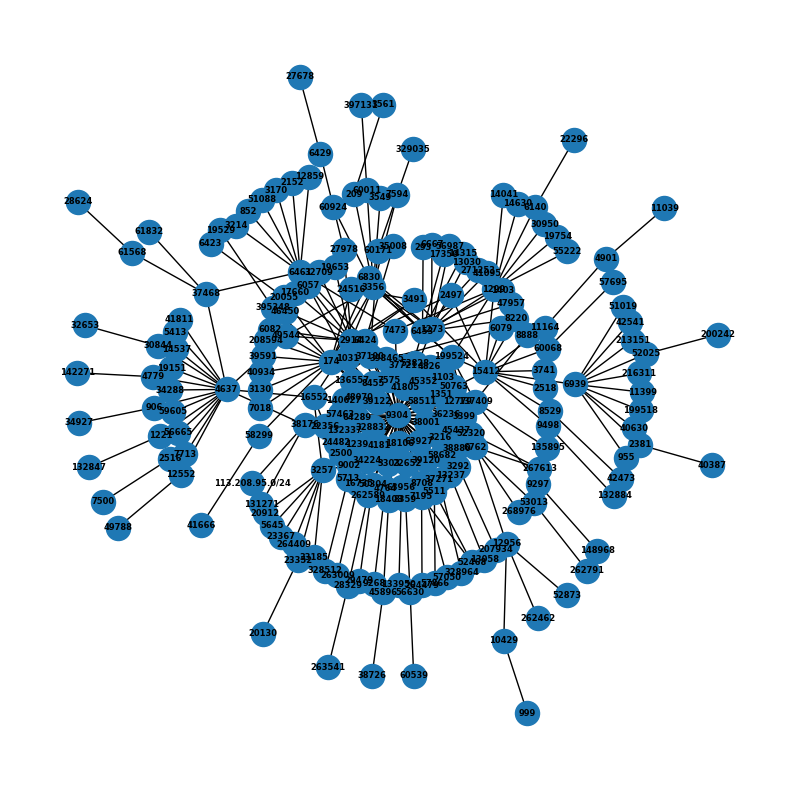

In [51]:
pos = nx.kamada_kawai_layout(as_graph_after)
ax = plt.subplots(1, figsize=(10, 10))
nx.draw(as_graph_rib, pos=pos, with_labels=True, font_weight='bold', font_size=6)
plt.savefig("ip11320895024_routeview_10_07_2024_175400_rib.png")

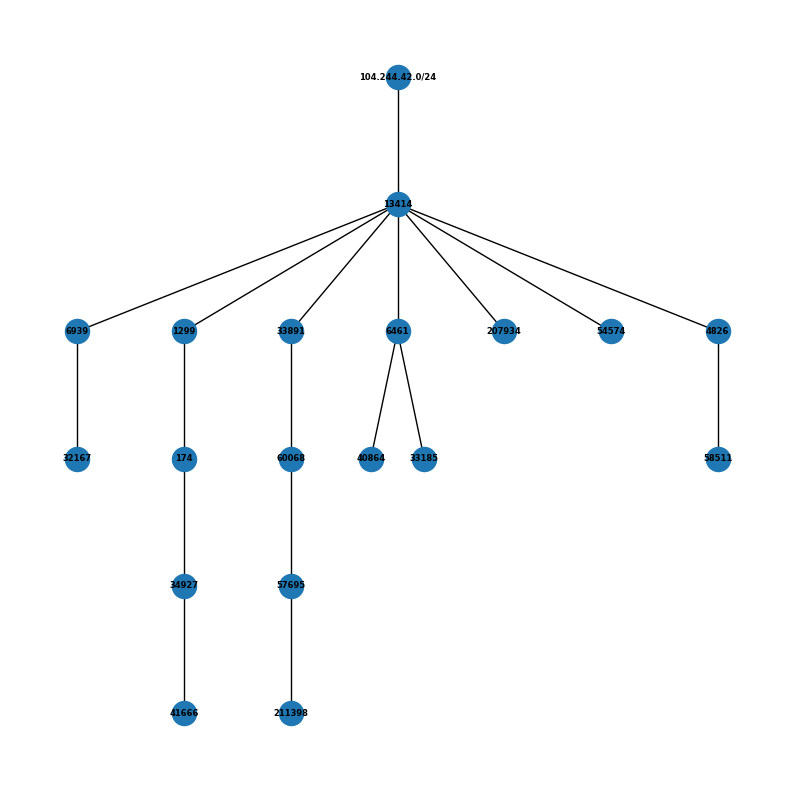

In [39]:
pos = hierarchy_pos(as_graph_before, '104.244.42.0/24')
#pos = nx.kamada_kawai_layout(as_graph_rib)
ax = plt.subplots(1, figsize=(10, 10))
nx.draw(as_graph_before, pos=pos, with_labels=True, font_weight='bold', font_size=6)
plt.savefig("13414_rv5_ip24_before_tree.png")

In [40]:
##Graph before incident
as_graph_after = nx.Graph()
for peer in prefix_13414_as_path_123000['104.244.42.0/24'].keys():
    as_path = prefix_13414_as_path_123000['104.244.42.0/24'][peer]
    for i in range(0, len(as_path)-1):
        as_graph_after.add_edge(as_path[i], as_path[i+1])
    if len(as_path) > 0:
        as_graph_after.add_edge(as_path[-1], '104.244.42.0/24')

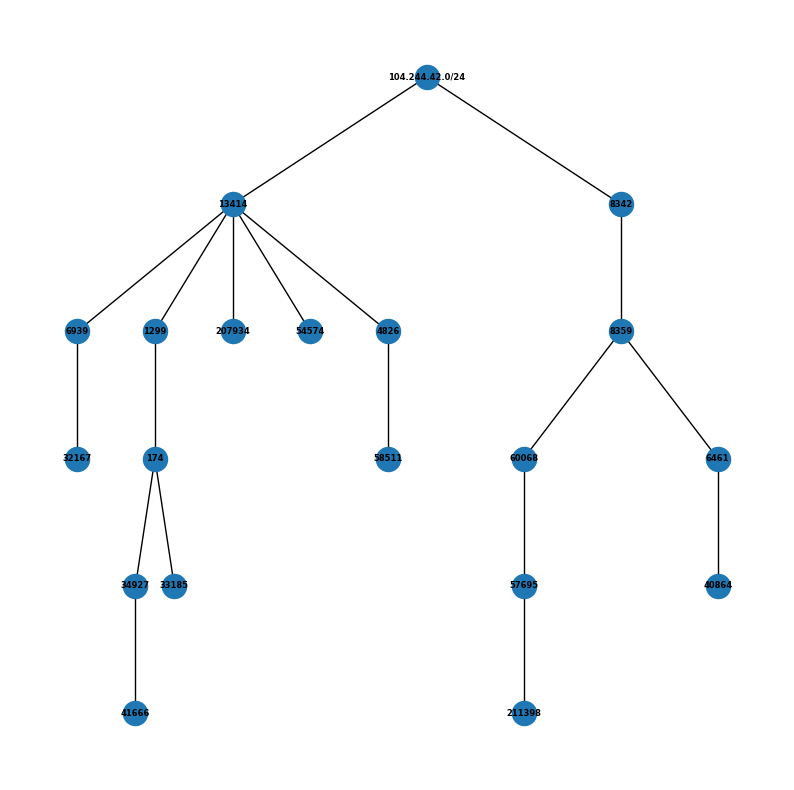

In [41]:
pos = hierarchy_pos(as_graph_after, '104.244.42.0/24')
#pos = nx.kamada_kawai_layout(as_graph_rib)
ax = plt.subplots(1, figsize=(10, 10))
nx.draw(as_graph_after, pos=pos, with_labels=True, font_weight='bold', font_size=6)
plt.savefig("13414_rv5_ip24_after_tree.png")

In [45]:
prefix_13414_as_path_123000['104.244.42.0/24']

{'32167': ['32167', '6939', '13414'],
 '41666': ['41666', '34927', '174', '1299', '13414'],
 '211398': ['211398', '57695', '60068', '8359', '8342'],
 '40864': ['40864', '6461', '8359', '8342'],
 '207934': ['207934', '13414'],
 '33185': ['33185', '174', '1299', '13414'],
 '54574': ['54574', '13414'],
 '58511': ['58511', '4826', '13414']}

In [46]:
stream2 = pybgpstream.BGPStream(
    from_time="2022-03-28 12:00:00 UTC", until_time="2022-03-28 13:00:00 UTC",
    collectors=["route-views2"],
    record_type="updates"
)

In [47]:
target_IP_messages = []
i = 0
types = {"A", "W"}
for rec in tqdm(stream2.records()):
    for elem in rec:
        i += 1
        if (str(elem.type) in types) and "prefix" in elem.fields:
            IP = str(elem.fields["prefix"])
            if IP == '104.244.42.0/24':
                print(elem)
                target_IP_messages.append(elem)

0it [00:00, ?it/s]

update|A|1648469184.467364|routeviews|route-views2|None|None|13030|213.144.128.203|104.244.42.0/24|213.144.128.203|13030 8359 8342|13030:1 13030:50000 13030:8222 13030:51202 13030:3|None|None
update|A|1648469190.262315|routeviews|route-views2|None|None|1403|198.58.198.252|104.244.42.0/24|198.58.198.252|1403 1299 13414 13414|1299:35000|None|None
update|A|1648469199.504047|routeviews|route-views2|None|None|22652|45.61.0.85|104.244.42.0/24|45.61.0.85|22652 8359 8342|8342:666 22652:51101 0:20940 8359:55277 22652:51005 8359:5500 63034:63034 22652:51359 22652:50003|None|None
update|A|1648469211.353582|routeviews|route-views2|None|None|3741|168.209.255.56|104.244.42.0/24|168.209.255.56|3741 8359 8342||None|None
update|A|1648471838.632990|routeviews|route-views2|None|None|13030|213.144.128.203|104.244.42.0/24|213.144.128.203|13030 13414 13414|13030:1 13030:50000 13030:4006 13030:51702 13030:7221 13030:1008|None|None
update|A|1648471842.980612|routeviews|route-views2|None|None|22652|45.61.0.85|

In [25]:
datetime.fromtimestamp(1648469213.677691)

datetime.datetime(2022, 3, 28, 12, 6, 53, 677691)